In [9]:
import lib.csv_helpers as csv
from IPython.display import display
import shutil

#Delete any existing dummy data
shutil.rmtree('dummydata')

## Generate Dummy Data
for testing / demo purposes.
Includes random surface chemistry mapping

In [1]:
import lib.csv_helpers as csv
from IPython.display import display
import lib.json_setup as json_setup

print("Generating metadata run list with the following settings")

# Start with the example setup dictionary
setup = csv.get_default_setup()

run_df = csv.generate_run_df(setup)
run_df
# Iterate through the run_df calling dummy_measurement for each row,
# Stores the results in the path/subdirs defined in setup. 
# csv.run_measure(setup, run_df, measure_func=csv.dummy_measurement)


Generating metadata run list with the following settings


,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
default_sensor-A01-waterA,NaT,default_instrument,default_sensor,A01,Al,None,waterA,3,
default_sensor-A02-waterA,NaT,default_instrument,default_sensor,A02,Au,None,waterA,3,
default_sensor-B01-waterA,NaT,default_instrument,default_sensor,B01,Al,HMDS,waterA,3,
default_sensor-B02-waterA,NaT,default_instrument,default_sensor,B02,Au,DT,waterA,3,
default_sensor-C01-waterA,NaT,default_instrument,default_sensor,C01,Al,PEG,waterA,3,
default_sensor-C02-waterA,NaT,default_instrument,default_sensor,C02,Au,PFDT,waterA,3,
default_sensor-A01-waterB,NaT,default_instrument,default_sensor,A01,Al,None,waterB,3,
default_sensor-A02-waterB,NaT,default_instrument,default_sensor,A02,Au,None,waterB,3,
default_sensor-B01-waterB,NaT,default_instrument,default_sensor,B01,Al,HMDS,waterB,3,


## Preview of csv spectrometer data
Simply displaying a csv measurement file with pandas

In [10]:
import os
import pandas as pd

# pd.options.display.max_rows= 15
dir = "dummydata/instrument01/waterA/"
testfile = "instrument01-A01-waterA.txt"
df = pd.read_csv(os.path.join(dir, testfile), sep='\t')

#label columns
reps = len(df.columns)-1
col_names = ['wavelength']
for r in range(reps):
	col_names.append(F"rep{r+1}")
df.columns = col_names
df

,wavelength,rep1,rep2,rep3,rep4,rep5,rep6
0,540.0,0.636037,0.788888,0.368024,0.260227,0.879727,0.414196
1,540.5,0.824837,0.350953,0.167499,0.742324,0.216747,0.599098
2,541.0,0.760054,0.709233,0.832965,0.295608,0.993233,0.339023
3,541.5,0.488788,0.708132,0.009932,0.611666,0.970723,0.036914
4,542.0,0.882736,0.036596,0.955018,0.277749,0.138286,0.087521
...,...,...,...,...,...,...,...
375,727.5,0.343285,0.828136,0.817357,0.225698,0.090470,0.268875
376,728.0,0.244205,0.366858,0.277609,0.514266,0.484996,0.836082
377,728.5,0.975111,0.450919,0.923167,0.682250,0.185712,0.455857
378,729.0,0.870955,0.024156,0.164604,0.144436,0.718655,0.541955


## Import from .txt or .csv files

### Input File

Requires a text file with at least 2 columns.
(They don't need to be named in the file)

[wavelength]	[transmission data 1]	...[transmission data n (optional)]

The default is for tab separation, but can be specified with:

separator = '\t'

### Regex
A regular expression must be provided to identify these Primary metadata fields from the filename:
* sensor
* element
* fluid

Optionally, extra fields can be identified, which will be added to the metadata:
* e.g. rotation


In [1]:
import lib.csv_helpers as csv
import lib.json_setup as json_setup
import os 
os.chdir('/Users/calum/spectrometer/')

#Folder containing text/csv files to import
input_dir = "HAN24data_raw/combined"

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
# regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(?P<rotation>.+).txt'
regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(.+).txt'

# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

csv.import_dir_to_csv(setup, input_dir, regex)

# can save the new setup if anything has been changed
# json_setup.dict_to_json(setup, setup_path, overwrite=False)

INFO:root:Saving into new file HAN24data\HAN24\BeerBitter1\HAN24-10-BeerBitter1.txt
INFO:root:Saving into new file HAN24data\index.txt
INFO:root:Merging into existing HAN24data\HAN24\BeerBitter1\HAN24-10-BeerBitter1.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Saving into new file HAN24data\HAN24\BeerBitter2\HAN24-10-BeerBitter2.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Merging into existing HAN24data\HAN24\BeerBitter2\HAN24-10-BeerBitter2.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Saving into new file HAN24data\HAN24\BeerBitter3\HAN24-10-BeerBitter3.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Merging into existing HAN24data\HAN24\BeerBitter3\HAN24-10-BeerBitter3.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Saving into new file HAN24data\HAN24\BeerCorny1\HAN24-10-BeerCorny1.txt
INFO:root:Merging into existing HAN24data\index.txt
INFO:root:Merging into existing HAN24data\HAN24\

## Example of searching by metadata

select_from_metadata() returns a list of h5 nodes that match the
criteria.

It can search a full h5 file, or if a nodelist is provided, it will work from
that.

Search criteria must include a metadata key, and can optionally include a
metadata value

In [30]:
import lib.csv_helpers as csv
import os
import pandas as pd

setup = csv.get_default_setup()
os.chdir('/Users/calum/spectrometer/')

# meta_df = csv.read_metadata(setup)

# meta_df = csv.select_from_metadata('sensor', 'HAN24', meta_df)
# meta_df = csv.select_from_metadata('element', '01', meta_df)

dtypes = {
    'name'              : 'default_metadata_columns',
    # Column            : #Datatype
    'index'             : 'string',
    'date'              : 'datetime64[ns]',
    'instrument'        : 'string',
    'sensor'            : 'string',
    'element'           : 'string',
    'structure'         : 'string',
    'surface'           : 'string',
    'fluid'             : 'string',
    'repeats'           : 'Int64',
    'comment'           : 'string',
}
dtypes.pop('date')
dtypes.pop('name')

metapath = os.path.join(setup['datadir'], setup['metafile'])

meta_df = pd.read_csv(metapath,
                        sep='\t',
                        index_col='index',
                        parse_dates=['date'],
                        dtype=dtypes,
                        keep_default_na = False
                        )

meta_df



,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
default_sensor-A01-waterA,2022-03-29,default_instrument,default_sensor,A01,Al,None,waterA,1,
default_sensor-A01-waterAaa,2022-03-29,default_instrument,default_sensor,A01,Al,None,waterAaa,1,


## Export with Preprocessing

export_dataframes() takes a meta_df listing which measurements to export.
(In this case we select only fluid==Beer from the full set)

A DataProcessor object may also be passed, which will be applied to the
measurements during export.




In [6]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup

os.chdir('/Users/calum/spectrometer/')


# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
meta_df = csv.select_from_metadata('element', '01', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = True
dp.apply_trim = True
dp.apply_interpolate = True
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1.0

merged_df, title = csv.merge_dataframes(setup, meta_df)

merged_df
df = dp.process_dataframe(merged_df)
print(title)

lib.data_process.plot(df)

export = csv.export_dataframes(setup, meta_df, dp=dp, outfile='export.txt')
export
# stats = csv.export_stats(setup, meta_df, dp=dp, outfile='export_stats.txt')
# stats


,wavelength,10_BeerBitter1_rep01,10_BeerBitter1_rep02,10_BeerBitter1_rep03,10_BeerBitter1_rep04,10_BeerBitter1_rep05,10_BeerBitter1_rep06,10_BeerBitter2_rep01,10_BeerBitter2_rep02,10_BeerBitter2_rep03,...,09_BeerMusty3_rep06,09_Beer_rep01,09_Beer_rep02,09_Beer_rep03,09_Beer_rep04,09_Beer_rep05,09_Beer_rep06,09_Beer_rep07,09_Beer_rep08,09_Beer_rep09
0,457.131,98.77,99.22,98.77,98.48,98.74,98.66,97.72,98.04,98.02,...,99.58,89.57,89.94,89.78,87.93,88.14,88.27,75.97,76.26,76.09
1,457.204,99.00,99.16,98.96,98.66,98.69,98.67,97.73,97.84,97.80,...,99.25,88.82,88.83,88.75,86.87,86.54,87.03,73.62,73.64,73.68
2,457.277,95.12,95.17,94.66,91.41,90.84,90.74,87.99,87.99,88.04,...,97.02,89.38,89.28,89.09,86.77,86.12,86.87,73.46,73.19,72.86
3,457.349,93.82,93.88,93.54,90.59,90.24,90.15,86.06,86.17,86.29,...,96.05,90.19,90.12,89.90,86.72,86.41,86.85,73.52,73.46,73.23
4,457.422,93.98,94.03,93.78,91.22,90.90,90.74,85.43,85.83,86.09,...,95.50,90.75,90.63,90.67,86.73,86.44,86.64,74.00,74.05,73.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,730.534,66.20,65.54,66.02,65.45,66.17,65.51,63.10,62.95,62.92,...,58.98,57.49,57.49,57.78,55.42,55.23,55.79,49.60,50.70,49.97
4091,730.598,66.68,66.14,66.71,66.65,66.32,66.26,64.13,63.52,63.67,...,59.60,56.81,57.28,56.15,57.69,55.51,56.99,49.32,49.57,49.75
4092,730.661,67.71,67.92,67.83,67.16,67.43,67.95,64.29,63.89,64.77,...,59.35,56.57,56.75,56.57,56.28,56.60,56.09,48.48,47.38,48.54
4093,730.724,66.41,67.32,66.72,65.54,66.87,67.35,63.69,64.89,64.74,...,60.01,56.98,57.82,59.59,55.49,57.20,56.44,48.75,49.06,49.24


## Process and Plot data

In [8]:
import lib.data_process
import os
import pandas as pd
import lib.csv_helpers as csv

setup = csv.get_default_setup()
meta_df = csv.read_metadata(setup)


dp = lib.data_process.DataProcessor()
dp.apply_interpolate = True
dp.apply_normalise = True
dp.apply_trim = True
dp.apply_smooth = True

meta_df = csv.select_from_metadata('sensor', 'DUM01', meta_df)

# meta_df = csv.select_from_metadata('element', '01', meta_df)

merged_df, title = csv.merge_dataframes(setup, meta_df)
df = dp.process_dataframe(merged_df)
print(title)
df

# lib.data_process.plot(df)


INFO:root:filtering by metadata "sensor" == "DUM01"


ValueError: arange: cannot compute length

In [1]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup

os.chdir('/Users/calum/spectrometer/')


# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
# meta_df = csv.select_from_metadata('element', '02', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = False
dp.apply_trim = True
dp.apply_interpolate = False
dp.apply_round = True

dp.smooth_points = 1
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1

csv.export_stats(setup, dp, meta_df, outfile='stats.txt')



INFO:root:filtering by metadata "fluid" == "Beer"
INFO:root:Writing to stats.txt ...
INFO:root:Done


,element,surface,fluid,FWHM,Height,Peak
0,01,NaN,Beer,70.26,0.64,663.63
1,01,NaN,Beer,70.39,0.64,663.63
2,01,NaN,Beer,70.26,0.64,663.63
3,01,NaN,Beer,68.04,0.65,654.03
4,01,NaN,Beer,68.10,0.65,653.96
...,...,...,...,...,...,...
130,15,NaN,Beer,73.31,0.70,672.70
131,15,NaN,Beer,73.24,0.71,672.82
132,15,NaN,Beer,71.85,0.67,671.80
133,15,NaN,Beer,71.72,0.67,671.86


## Bulk Process
copy one dataset into another, can also be used for modifying a folder structure

In [1]:
import os
import lib.csv_helpers as csv
import pandas as pd

path='./dummydata'
metapath = os.path.join(path, "index.txt")

setup_in = csv.get_default_setup()
setup_out = csv.get_default_setup()

setup_out['path'] = 'bulkmerge_output'
setup_out['subdirs'] = ['sensor', 'fluid']

csv.bulk_process(setup_in, setup_out, delete_input=False, merge_out=False)


ERROR:root:[Errno 2] No such file or directory: 'dummydata/instrument01/waterA/instrument01-A01-waterA.txt'
Row will be removed from output metadata file
Check that setup_in['subdirs'] is set correctly
ERROR:root:[Errno 2] No such file or directory: 'dummydata/instrument01/waterA/instrument01-A02-waterA.txt'
Row will be removed from output metadata file
Check that setup_in['subdirs'] is set correctly
ERROR:root:[Errno 2] No such file or directory: 'dummydata/instrument01/waterA/instrument01-B01-waterA.txt'
Row will be removed from output metadata file
Check that setup_in['subdirs'] is set correctly
ERROR:root:[Errno 2] No such file or directory: 'dummydata/instrument01/waterA/instrument01-B02-waterA.txt'
Row will be removed from output metadata file
Check that setup_in['subdirs'] is set correctly
ERROR:root:[Errno 2] No such file or directory: 'dummydata/instrument01/waterA/instrument01-C01-waterA.txt'
Row will be removed from output metadata file
Check that setup_in['subdirs'] is set 

## Single Measurements

Run some dummy measurements at various wavelengths to check they merge correctly

In [18]:
import lib.csv_helpers as csv

setup = csv.get_default_setup()
element = 'A02'
fluid = 'asdf'

setup['wavelength_range'] = [400, 420, 0.5]
csv.simple_measurement(setup, element, fluid, csv.dummy_measurement)
setup['wavelength_range'] = [390, 410, 0.5]
df = csv.simple_measurement(setup, element, fluid, csv.dummy_measurement)
df




INFO:root:Saving into new file dummydata/instrument01/asdf/instrument01-A02-asdf.txt
INFO:root:Merging into existing dummydata/index.txt
INFO:root:Merging into existing dummydata/instrument01/asdf/instrument01-A02-asdf.txt
INFO:root:Merging into existing dummydata/index.txt


,wavelength,1647256382.994453,1647256383.020605
0,390.0,NaN,0.934341
1,390.5,NaN,0.159506
2,391.0,NaN,0.485793
3,391.5,NaN,0.118181
4,392.0,NaN,0.181326
5,392.5,NaN,0.432854
6,393.0,NaN,0.744847
7,393.5,NaN,0.435029
8,394.0,NaN,0.910408
9,394.5,NaN,0.973651


In [7]:
import time
import numpy as np

# import the usb driver
import stellarnet_mac.stellarnet_driver3 as sn

import logging
logging.basicConfig(format='%(asctime)s %(message)s')

def getSpectrum(spectrometer, wav, inttime, scansavg, smooth):
    logging.warning('requesting spectrum')
    spectrometer['device'].set_config(int_time=inttime, scans_to_avg=scansavg, x_smooth=smooth)
    spectrometer['device'].print_info()
    spectrum = sn.array_spectrum(spectrometer, wav)
    logging.warning('recieved spectrum')
    return spectrum
    
spectrometer, wav = sn.array_get_spec(0)


       
inttime = 100
scansavg = 1
smooth = 1 

logging.warning('displaying spectrum')
data=getSpectrum(spectrometer, wav, inttime, scansavg, smooth)
data



2022-03-18 14:16:53,270 displaying spectrum
2022-03-18 14:16:53,270 requesting spectrum


--- Device Information
idVendor:      0BD7
idProduct:     A012


USBError: [Errno 32] Pipe error

In [16]:
import pymongo

connection = pymongo.MongoClient('localhost', 27017)

database = connection['mydb_01']

collection = database['mycollection01']

data = {'name' : 'Calum'}

collection.insert_one(data)

collection.update_one

In [3]:
import lib.csv_helpers as csv
import lib.json_setup as json_setup
import os
os.chdir('/Users/calum/spectrometer/')

#Folder containing text/csv files to import
input_dir = "/Users/calum/git/Glasgow/sampleData/combined"

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
# regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(?P<rotation>.+).txt'
regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(.+).txt'

# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)
meta_df = csv.read_metadata(setup)
csv.write_meta_df_txt(setup, meta_df)
meta_df


# meta_df.to_csv(temp_buffer, index=True, sep='\t', na_rep='', date_format='%Y-%m-%d')
# temp_buffer.seek(0)
# temp_buffer.read()
# mod_df = pd.read_csv(temp_buffer,
#                         sep='\t',
#                         index_col='index',
#                         parse_dates=['date'],
#                         dtype=dtypes,
#                         keep_default_na = False
#                         )

# mod_df
# csv.import_dir_to_csv(setup, input_dir, regex)
# json_setup.dict_to_json(setup, setup_path, overwrite=False)

{'name': 'HAN24',
 'category': 'setup',
 'metafile': 'index.txt',
 'datadir': 'dummydata',
 'subdirs': ['sensor', 'fluid'],
 'primary_metadata': ['sensor', 'element', 'fluid'],
 'instrument': {'name': 'default_instrument',
  'category': 'instrument',
  'light Source': 'Stellarnet LED White',
  'spectrometer': 'Stellarnet BlueWave VIS-25'},
 'sensor': {'name': 'HAN24',
  'category': 'sensor',
  'layout': {'name': 'HAN24_layout',
   'category': 'layout',
   'map': {'01': ['', ''],
    '02': ['', ''],
    '03': ['', ''],
    '04': ['', ''],
    '05': ['', ''],
    '06': ['', ''],
    '07': ['', ''],
    '08': ['', ''],
    '09': ['', ''],
    '10': ['', ''],
    '11': ['', ''],
    '12': ['', ''],
    '13': ['', ''],
    '14': ['', ''],
    '15': ['', '']}},
  'structure_map': {'name': 'HAN24_structure',
   'category': 'structure_map',
   'valid_layout': 'HAN24_layout',
   'map': {'01': ['', ''],
    '02': ['', ''],
    '03': ['', ''],
    '04': ['', ''],
    '05': ['', ''],
    '06': [''

,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
default_sensor-A01-waterA,2022-03-30,default_instrument,default_sensor,A01,Al,None,waterA,2,
default_sensor-A01-waterAaa,2022-03-30,default_instrument,default_sensor,A01,Al,None,waterAaa,1,
HAN24-10-BeerBitter1,2022-03-30,default_instrument,HAN24,10,,,BeerBitter1,24,
HAN24-10-BeerBitter2,2022-03-30,default_instrument,HAN24,10,,,BeerBitter2,24,
HAN24-10-BeerBitter3,2022-03-30,default_instrument,HAN24,10,,,BeerBitter3,24,
...,...,...,...,...,...,...,...,...,...
HAN24-09-BeerCorny3,2022-03-30,HAN24sample,HAN24,09,s,s,BeerCorny3,6,
HAN24-09-BeerMusty1,2022-03-30,HAN24sample,HAN24,09,s,s,BeerMusty1,6,
HAN24-09-BeerMusty2,2022-03-30,HAN24sample,HAN24,09,s,s,BeerMusty2,6,


INFO:root:Merging into existing dummydata/index.txt


,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
default_sensor-A01-waterA,2022-03-30,default_instrument,default_sensor,A01,Al,None,waterA,2,
default_sensor-A01-waterAaa,2022-03-30,default_instrument,default_sensor,A01,Al,None,waterAaa,1,
HAN24-10-BeerBitter1,2022-03-30,default_instrument,HAN24,10,,,BeerBitter1,24,
HAN24-10-BeerBitter2,2022-03-30,default_instrument,HAN24,10,,,BeerBitter2,24,
HAN24-10-BeerBitter3,2022-03-30,default_instrument,HAN24,10,,,BeerBitter3,24,
...,...,...,...,...,...,...,...,...,...
HAN24-09-BeerCorny3,2022-03-30,HAN24sample,HAN24,09,s,s,BeerCorny3,6,
HAN24-09-BeerMusty1,2022-03-30,HAN24sample,HAN24,09,s,s,BeerMusty1,6,
HAN24-09-BeerMusty2,2022-03-30,HAN24sample,HAN24,09,s,s,BeerMusty2,6,


INFO:root:filtering by metadata "fluid" == "Beer"
INFO:root:filtering by metadata "element" == "01"


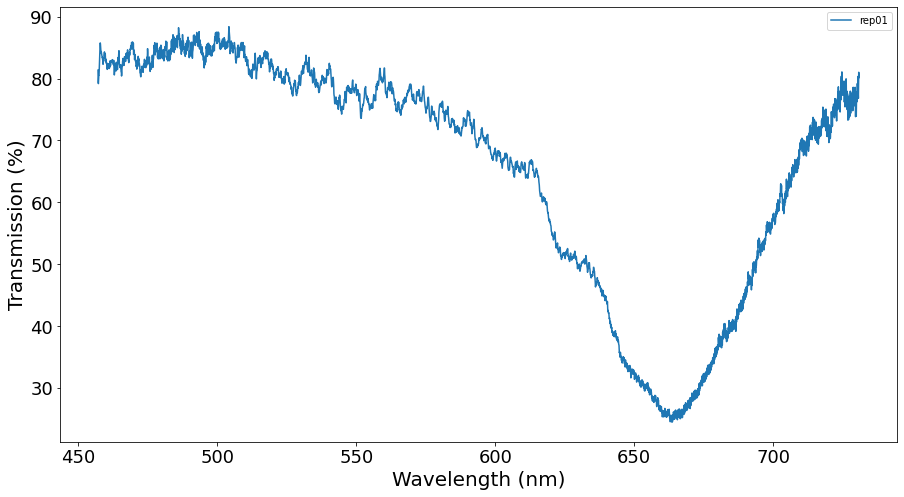

baseline=82.5558 height=58.015800000000006 hm=53.5479 72.80500000000006


(72.80500000000006, 58.015800000000006, 82.5558)

In [30]:
import lib.csv_helpers as csv
import lib.data_process
os.chdir('/Users/calum/spectrometer/')


setup = csv.get_default_setup()
meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
meta_df = csv.select_from_metadata('element', '01', meta_df)
# meta_df = csv.select_from_metadata('sensor', 'DUM01', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = True
dp.apply_trim = True
dp.apply_interpolate = True
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1.0

data = csv.merge_dataframes(setup, meta_df)
# data[0].iloc[:, :2]
df = data[0].iloc[:, :2]
lib.data_process.plot(df)

for col in df:
    if col == 'wavelength':
        pass
    else:
        baseline=df[col][1:101].mean()
        min = df[col][1:].min()
        height = baseline - min
        hm = min + (height/2)
        flagdown=0
        flagup=0
        for i in range(30,len(df[col])):
            value=df[col][i]
            if value<=hm and flagdown==0:
                flagdown=1
                side1=df['wavelength'][i]
            if value>=hm and flagdown==1 and flagup==0 and df['wavelength'][i]-side1>10:
                flagup=1
                side2=df['wavelength'][i]
            if flagup==1 and flagdown==1:
                break
        if flagup==0:
            side2=0
            side1=0
        fwhm_num=side2-side1
        print(f'{baseline=} {height=} {hm=} {fwhm_num}')

# export = csv.export_dataframes(setup, meta_df, dp=dp, outfile='export.txt')
# export